In [1]:
import torch
import torch.nn as nn

# Model

In [2]:
# --- Encoder ---
class AudioEncoder(nn.Module):
    def __init__(self, input_channels=1, conv_channels=32, transformer_dim=256, num_layers=4):
        super(AudioEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.MaxPool1d(kernel_size=441, stride=441),  # [B, 441000] → [B, 1, 1000]
            nn.Conv1d(input_channels, conv_channels, kernel_size=10, stride=10, padding=0),  # [B, 1, 1000] → [B, 32, 100]
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
            nn.Conv1d(conv_channels, 2 * conv_channels, kernel_size=12, stride=4, padding=4),   # [B, 32, 100] → [B, 32, 25]
            nn.BatchNorm1d(2 * conv_channels),
            nn.ReLU(),
            nn.Conv1d(2 * conv_channels, conv_channels, kernel_size=5, stride=1, padding=2),   # [B, 32, 25] → [B, 32, 25]
        )


        # self.pos_encoder = nn.Parameter(torch.randn(1, 100, transformer_dim))  # Pos encoding
        self.linear_proj = nn.Linear(conv_channels, transformer_dim)             # [B, 32, 25] → [B, 25, 256]

        # encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=8)
        # self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 441000] → [B, 1, 441000]
        x = torch.abs(x)
        x = self.conv(x)    # → [B, 256, 25]
        x = x.permute(0, 2, 1)  # → [B, 25, 256]
        x = self.linear_proj(x)  # → [B, 25, 256]
        # x = x + self.pos_encoder[:, :x.size(1)]  # Add positional encoding
        # x = x.permute(1, 0, 2)  # → [4410, B, 256] for Transformer
        # x = self.transformer(x)  # → [4410, B, 256]
        # x = x.permute(1, 0, 2)  # → [B, 4410, 256]
        # Commenting out the transformer for simplicity
        return x

In [3]:
class AudioDecoder(nn.Module):
    def __init__(self, transformer_dim=256, num_classes=10):
        super(AudioDecoder, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)  # → [B, 256, 1]
        self.classifier = nn.Linear(transformer_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, 100, 256] → [B, 256, 100]
        x = self.pool(x).squeeze(-1)  # → [B, 256]
        x = self.classifier(x)  # → [B, 10]
        return x

In [4]:
# --- Full Model ---
class ConvTransformerAudioClassifier(nn.Module):
    def __init__(self):
        super(ConvTransformerAudioClassifier, self).__init__()
        self.encoder = AudioEncoder()
        self.decoder = AudioDecoder()

    def forward(self, x):
        encoded = self.encoder(x)  # → [B, ~11025, 256]
        logits = self.decoder(encoded)  # → [B, 10]
        return logits


In [5]:
model = ConvTransformerAudioClassifier()

model.eval()

ConvTransformerAudioClassifier(
  (encoder): AudioEncoder(
    (conv): Sequential(
      (0): MaxPool1d(kernel_size=441, stride=441, padding=0, dilation=1, ceil_mode=False)
      (1): Conv1d(1, 32, kernel_size=(10,), stride=(10,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(12,), stride=(4,), padding=(4,))
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (linear_proj): Linear(in_features=32, out_features=256, bias=True)
  )
  (decoder): AudioDecoder(
    (pool): AdaptiveAvgPool1d(output_size=1)
    (classifier): Linear(in_features=256, out_features=10, bias=True)
  )
)

# Training

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output, display, Markdown

def train_model(model, train_loader, test_loader, epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', save_path='best_model.pth'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    criterion = nn.BCEWithLogitsLoss()

    test_accuracies = []
    best_test_accuracy = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0
        total_batches = 0
        
        with tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training", unit="batch", leave=False) as pbar:
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                y_labels = y.float()

                optimizer.zero_grad()
                preds = model(x)
                loss = criterion(preds, y_labels)
                loss.backward()
                optimizer.step()

                predicted = torch.sigmoid(preds) > 0.5
                acc = (predicted == y_labels.bool()).float().mean() * 100
                

                running_loss += loss.item()
                total_batches += 1

                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{acc.item():.2f}'
                })

        train_loss = running_loss / total_batches if total_batches > 0 else 0

        model.eval()
        total_correct = 0
        total_count = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_labels = y.float()
                preds = model(x)
                predicted = torch.sigmoid(preds) > 0.5
                correct = (predicted == y_labels.bool()).sum()
                total_correct += correct.item()
                total_count += y.numel()

        test_acc = (total_correct / total_count) * 100
        scheduler.step(test_acc)
        test_accuracies.append(test_acc)

        # Save model if best
        if test_acc > best_test_accuracy:
            torch.save(model.state_dict(), save_path)
            best_test_accuracy = test_acc

        # Clear output and display updated results
        clear_output(wait=True)
        display(Markdown(f"### 📘 Epoch {epoch} Results"))
        display(Markdown(f"- **Train Loss**: `{train_loss:.4f}`"))
        display(Markdown(f"- **Test Accuracy**: `{test_acc:.2f}`"))
        display(Markdown(f"- **Best Accuracy So Far**: `{best_test_accuracy:.2f}`"))

        # Plot accuracy progression
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', color='royalblue')
        plt.title("📈 Test Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Test Accuracy (%)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [7]:
from src.dataExt import *

train_loader = MusicNetLoader(root=os.path.expanduser("~/data/musicnet"), label="train")
test_loader = MusicNetLoader(root=os.path.expanduser("~/data/musicnet"), label="test")

train_dataloader = train_loader.get_loader(batch_size=1000)
test_dataloader = test_loader.get_loader(batch_size=1000)

Found instrument IDs: [43]
Found instrument IDs: [61 72 71]


### 📘 Epoch 71 Results

- **Train Loss**: `0.2577`

- **Test Accuracy**: `85.10`

- **Best Accuracy So Far**: `85.10`

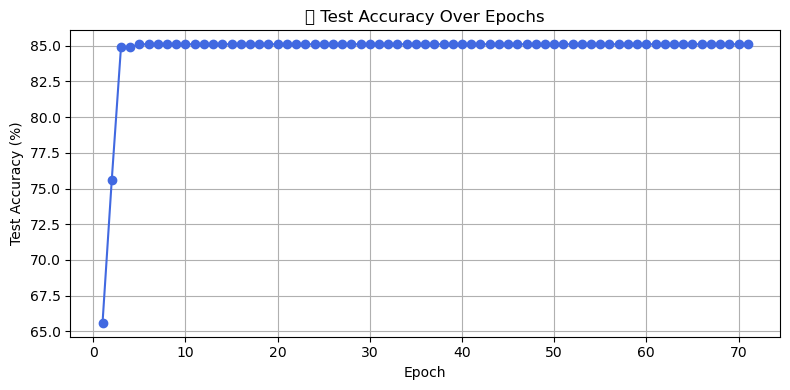

KeyboardInterrupt: 

In [8]:
train_model(model, train_dataloader, test_dataloader, epochs=100, save_path='../models/my_best_model.pth')

In [9]:
# Save the model
torch.save(model.state_dict(), '../models/my_model.pth')

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model_adv(model, train_loader, test_loader, epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', save_path='best_model.pth'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()


    test_accuracies = []
    best_test_accuracy = 0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        model.train()
        
        with tqdm(train_loader, desc=f"Training", unit="batch", leave=False) as pbar:
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                
                y_labels = y.float()
                
                optimizer.zero_grad()
                preds = model(x)
                loss = criterion(preds, y_labels)


                    
                loss.backward()
                optimizer.step()


                
                # Calculate metrics
                # Get binary predictions
                predicted = torch.sigmoid(preds) > 0.5

                # Mask where both prediction and actual are 0 → ignore those
                mask = ~((predicted == 0) & (y_labels == 0))

                # Compute accuracy only over unmasked elements
                if mask.sum() > 0:
                    acc = (predicted[mask] == y_labels[mask].bool()).float().mean() * 100
                else:
                    acc = torch.tensor(0.0, device=device)


                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{acc.item():.4f}'
                })
                

        # Validation
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_labels = y.float() # Convert test labels too
                preds = model(x)
                predicted = torch.sigmoid(preds) > 0.5
                mask = ~((predicted == 0) & (y_labels == 0))
                if mask.sum() > 0:
                    batch_acc = (predicted[mask] == y_labels[mask].bool()).float().mean()
                else:
                    batch_acc = torch.tensor(0.0, device=device)

                total_correct += batch_acc

                total_samples += y.size(0)
        
        test_acc = (total_correct / total_samples) * 100
        test_accuracies.append(test_acc)

        if test_acc > best_test_accuracy:
            torch.save(model.state_dict(), save_path)
            print(f"Test accuracy improved ({best_test_accuracy:.4f} → {test_acc:.4f}). Model saved to {save_path}")
            best_test_accuracy = test_acc

        print(f"Test Accuracy: {test_acc:.4f} (Best: {best_test_accuracy:.4f})")
        print(f"Accuracy History: {[f'{a:.4f}' for a in test_accuracies]}")

        plt.figure(figsize=(6, 4))
        plt.plot(range(1, epoch+1), test_accuracies, marker='o')
        plt.title('Test Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()

In [ ]:
train_model_adv(model, train_dataloader, test_dataloader, epochs=1, save_path='../models/my_best_model.pth')

In [ ]:
for x, y in test_dataloader:
    print(x)
    print(y)
    break